In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2024-10-20 21:20:54.315916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the training data
train_df = pd.read_csv('TRAIN_Reco_2021_2022_2023.csv')

# Display the first few rows
train_df.head()

,ExecutionTime,ID,high,low,close,volume
0,2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
1,2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2,2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
3,2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
4,2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0


In [3]:
# Get the number of unique items in the 'ID' column
unique_items_count = train_df['ID'].nunique()

unique_items_count


672

In [4]:
# Check for missing values in the dataset
train_df.isnull().sum()

ExecutionTime    0
ID               0
high             0
low              0
close            0
volume           0
dtype: int64

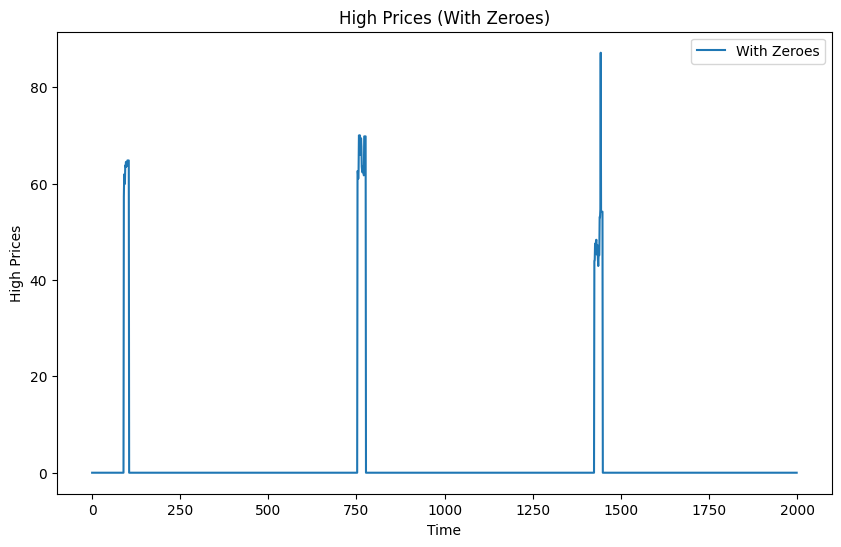

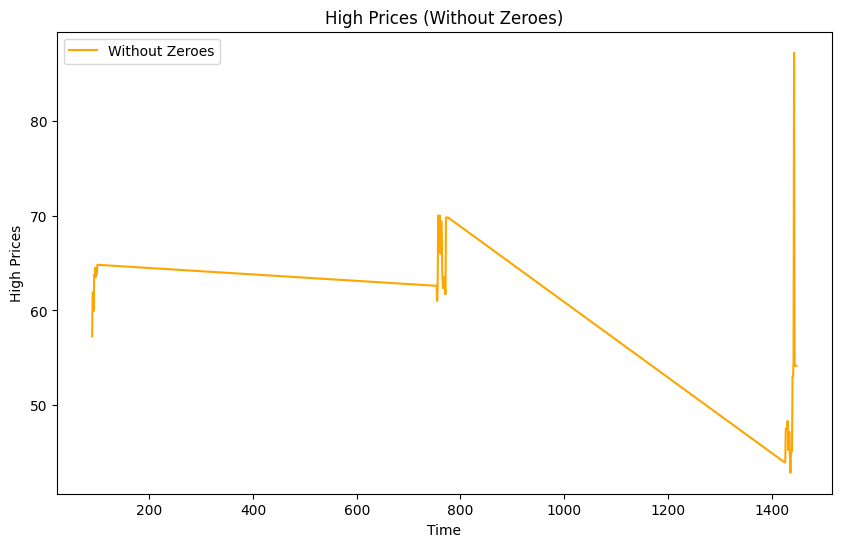

In [5]:
import matplotlib.pyplot as plt

# Take a sample of the data (e.g., first 2000 rows) to visualize
sample_data = train_df.head(2000)

# Plot the data with zeros
plt.figure(figsize=(10, 6))
plt.plot(sample_data.index, sample_data['high'], label='With Zeroes')
plt.title('High Prices (With Zeroes)')
plt.xlabel('Time')
plt.ylabel('High Prices')
plt.legend()
plt.show()

# Now remove rows where 'high', 'low', 'close', and 'volume' are all zero
sample_data_no_zeroes = sample_data[(sample_data['high'] != 0) | 
                                    (sample_data['low'] != 0) | 
                                    (sample_data['close'] != 0) | 
                                    (sample_data['volume'] != 0)]

# Plot the data without zeros
plt.figure(figsize=(10, 6))
plt.plot(sample_data_no_zeroes.index, sample_data_no_zeroes['high'], label='Without Zeroes', color='orange')
plt.title('High Prices (Without Zeroes)')
plt.xlabel('Time')
plt.ylabel('High Prices')
plt.legend()
plt.show()


/var/folders/v6/h5rtvpl56rd7c9hfh1v6xr540000gn/T/ipykernel_17169/195760148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data.loc[:, 'active_state'] = ((sample_data['high'] != 0) |


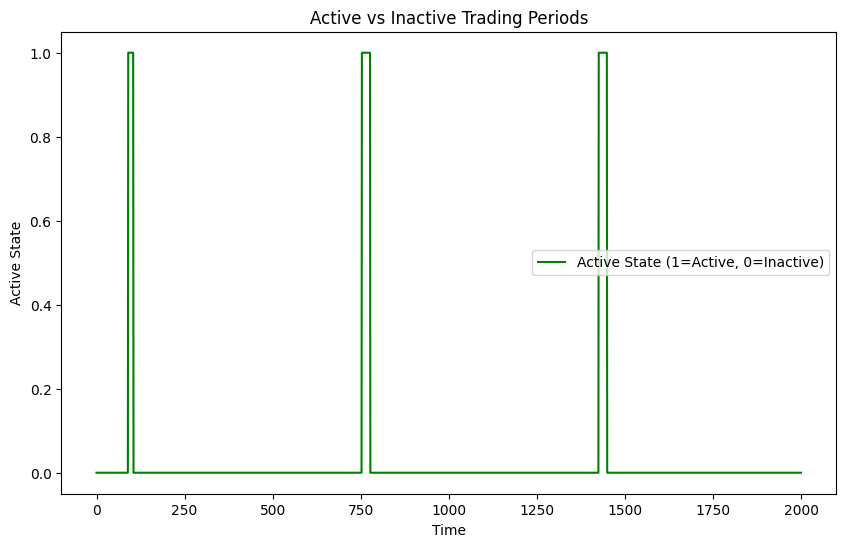

In [6]:
# Create a new column to indicate "active" or "inactive" trading periods
# Active (1) if any of 'high', 'low', 'close', or 'volume' is non-zero; Inactive (0) otherwise
train_df['active_state'] = ((train_df['high'] != 0) | 
                            (train_df['low'] != 0) | 
                            (train_df['close'] != 0) | 
                            (train_df['volume'] != 0)).astype(int)

# Visualize the active/inactive state for the sample data
sample_data.loc[:, 'active_state'] = ((sample_data['high'] != 0) | 
                                      (sample_data['low'] != 0) | 
                                      (sample_data['close'] != 0) | 
                                      (sample_data['volume'] != 0)).astype(int)


plt.figure(figsize=(10, 6))
plt.plot(sample_data.index, sample_data['active_state'], label='Active State (1=Active, 0=Inactive)', color='green')
plt.title('Active vs Inactive Trading Periods')
plt.xlabel('Time')
plt.ylabel('Active State')
plt.legend()
plt.show()


In [7]:
# Get basic statistics about the dataset
train_df.describe()

,high,low,close,volume,active_state
count,6.980534e+07,6.980534e+07,6.980534e+07,6.980534e+07,6.980534e+07
mean,1.799083e+01,1.729653e+01,1.764136e+01,4.928854e-01,1.167872e-01
std,6.549830e+01,6.312981e+01,6.423582e+01,4.188777e+00,3.211666e-01
min,-2.318860e+03,-2.882710e+03,-2.318860e+03,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.999000e+03,7.655300e+03,9.000000e+03,1.201825e+03,1.000000e+00


In [8]:
# Check the data types of each column
train_df.dtypes

ExecutionTime     object
ID                object
high             float64
low              float64
close            float64
volume           float64
active_state       int64
dtype: object

In [9]:
train_df.head()

,ExecutionTime,ID,high,low,close,volume,active_state
0,2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,0
1,2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,0
2,2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,0
3,2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,0
4,2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,0


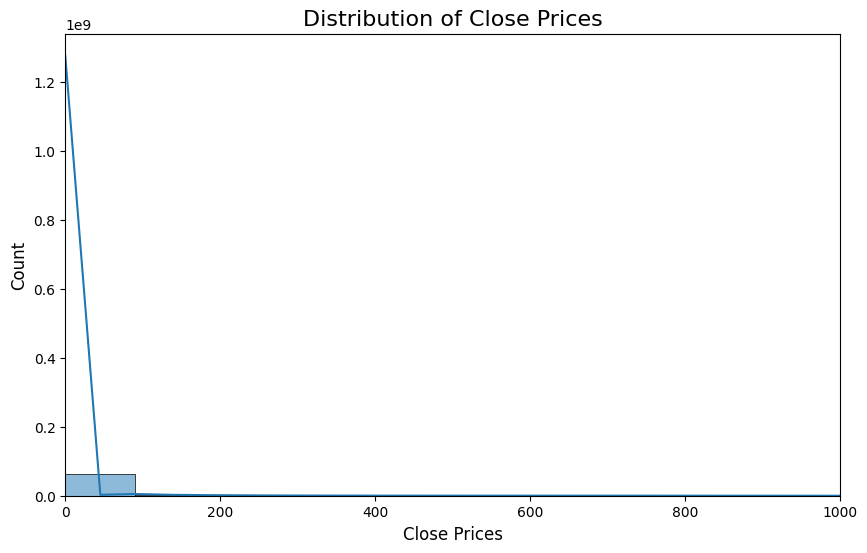

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out negative values for 'close' column
filtered_data = train_df[train_df['close'] >= 0]

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['close'], bins=100, kde=True)  # Increased bins for better resolution
plt.title('Distribution of Close Prices', fontsize=16)
plt.xlabel('Close Prices', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set a more reasonable limit on x-axis to focus on relevant range
plt.xlim(0, 1000)  # Adjust the limit as needed to focus on relevant data
plt.show()


**LSTM - without active state as a feature**

Step 1: Data Preparation

1.1 Prepare Data for Scenario 1

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your dataset into a dataframe 'train_df'
# Assuming your data is in a similar format with columns: ['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume', 'active_state']

# Step 1: Pivot the Data to Combine Features for All Assets
# This step reshapes the dataframe so that each asset has its own columns for high, low, close, volume

combined_df_pivot = train_df.pivot_table(index='ExecutionTime', 
                                         columns='ID', 
                                         values=['high', 'low', 'close', 'volume'])

# Flatten the multi-level columns to get individual columns for each asset's HLCV data
combined_df_pivot.columns = ['_'.join(map(str, col)).strip() for col in combined_df_pivot.columns.values]

# Convert the pivoted dataframe to numpy array for easier handling
combined_features = combined_df_pivot.values

# Check the shape of the combined features
print(f"Shape of combined_features: {combined_features.shape}")
# It should be (number_of_timesteps, 4 * num_assets), where 4 = (HLCV)

Shape of combined_features: (103877, 2688)


Step 2: Creating Sliding Windows for All Assets

Now, we will reshape the dataset to handle multiple assets together while preparing for LSTM input.

Sliding Window: The sliding window approach means that instead of processing the entire dataset in one go, the model is trained on sequential windows of data. This reduces the load on memory and allows you to efficiently train on a smaller portion of the dataset.

In [12]:
# Function to perform systematic sampling
def systematic_sampling(data, reduction_ratio=0.2):
    """
    Perform systematic sampling to reduce the number of samples.
    
    Args:
    data: The input data (e.g., combined_features).
    reduction_ratio: The fraction of data to retain (e.g., 0.2 for 20% of the original data).
    
    Returns:
    data_sampled: Systematically sampled input data.
    """
    k = int(1 / reduction_ratio)
    indices = np.arange(0, len(data), k)  # Systematically select every k-th sample
    return data[indices]

# Apply systematic sampling to reduce the dataset by 80% (keeping only 20%)
combined_features_sampled = systematic_sampling(combined_features, reduction_ratio=0.2)

# Check the shape of the sampled data
print(f"Shape of combined_features_sampled: {combined_features_sampled.shape}")


Shape of combined_features_sampled: (20776, 2688)


Step 2: Creating Sliding Windows for All Assets

Now, we will reshape the dataset to handle multiple assets together while preparing for LSTM input.

Sliding Window: The sliding window approach means that instead of processing the entire dataset in one go, the model is trained on sequential windows of data. This reduces the load on memory and allows you to efficiently train on a smaller portion of the dataset.

In [13]:
# Step 2: Define the Sliding Window Function
def create_sliding_window_data(data, window_size=30, prediction_size=10):
    """
    Create sliding windows from the data.
    
    Args:
    data: The input data (e.g., combined_features_sampled).
    window_size: The number of past timesteps to use for predicting the future.
    prediction_size: The number of future timesteps to predict.
    
    Returns:
    X: Input sequences for model (samples, window_size, features).
    y: Corresponding output sequences for model (samples, prediction_size, features).
    """
    X, y = [], []
    
    for i in range(len(data) - window_size - prediction_size):
        # Capture 'window_size' timesteps for all assets (HLCV for each asset)
        X.append(data[i:i + window_size, :])
        # Capture 'prediction_size' future timesteps for prediction
        y.append(data[i + window_size:i + window_size + prediction_size, :])
    
    return np.array(X), np.array(y)

# Step 3: Apply the Sliding Window Function on the Sampled Data
# Set the sliding window and prediction sizes
window_size = 30
prediction_size = 10

# Apply sliding window function on the sampled data
X_train, y_train = create_sliding_window_data(combined_features_sampled, window_size=window_size, prediction_size=prediction_size)

# Check the shape of X_train and y_train
print(f"X_train shape: {X_train.shape}")  # Should be (samples, window_size, features)
print(f"y_train shape: {y_train.shape}")  # Should be (samples, prediction_size, features)


X_train shape: (20736, 30, 2688)
y_train shape: (20736, 10, 2688)


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, RepeatVector
from sklearn.preprocessing import MinMaxScaler

# Step 1: Fit MinMaxScaler on the subsampled training data (for both X and y)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Flatten X_train_sampled and y_train_sampled for scaling, and then reshape back to the original shape
X_train_sampled_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_sampled_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

# Define the LSTM model
model = Sequential()
# Add an explicit Input layer
model.add(Input(shape=(30, 2688)))  # Using window size of 30 and 2688 features

# Add the first LSTM layer with 128 units and return sequences (since another LSTM follows)
model.add(LSTM(128, return_sequences=True))  # Using window size of 30 as per sliding window
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Add the second LSTM layer with 64 units and return sequences (to match the time steps)
model.add(LSTM(64, return_sequences=False))  # Return sequences to keep the time steps

# Add a RepeatVector to ensure output matches the 10 timesteps required for prediction
model.add(RepeatVector(10))  # Repeat the last output for 10 timesteps

# Add a Dense layer to predict the next 10 timesteps for each asset
model.add(TimeDistributed(Dense(2688)))  # 4 (HLCV) * 672 assets per timestep

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model using the scaled data
history = model.fit(X_train_sampled_scaled, y_train_sampled_scaled, epochs=20, batch_size=32)

# Print model summary to see the architecture
model.summary()


Epoch 1/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 109s 158ms/step - loss: 0.0049 - mae: 0.0317
Epoch 2/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 108s 167ms/step - loss: 0.0017 - mae: 0.0162
Epoch 3/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 111s 172ms/step - loss: 0.0016 - mae: 0.0151
Epoch 4/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 99s 153ms/step - loss: 0.0016 - mae: 0.0146
Epoch 5/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 101s 155ms/step - loss: 0.0015 - mae: 0.0142
Epoch 6/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 96s 148ms/step - loss: 0.0015 - mae: 0.0140
Epoch 7/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 115s 178ms/step - loss: 0.0015 - mae: 0.0135
Epoch 8/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 104s 160ms/step - loss: 0.0015 - mae: 0.0134
Epoch 9/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 108s 166ms/step - loss: 0.0015 - mae: 0.0133
Epoch 10/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 100s 154ms/step - loss: 0.0015 - mae: 0.0132
Epoch 11/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 101s 156ms/step - loss: 0.0015 - mae: 0.0130
Epoch 12/20
648/648 ━━━━━━━━━━━━━━━━━━━━ 98s 150ms/step - loss: 0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 128)        │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 2688)       │       174,720 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,999,298 (19.07 MB)

 Trainable params: 1,666,432 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,332,866 (12.71 MB)

In [27]:
import pandas as pd
import numpy as np

test_df = pd.read_csv('TEST_Reco_2024.csv')

# Step 1: Pivot the test data to get columns for each asset, with HLCV as separate columns
test_df_pivot = test_df.pivot_table(index='ExecutionTime', 
                                    columns='ID', 
                                    values=['high', 'low', 'close', 'volume'])

# Flatten the multi-level columns to get individual columns for each asset's HLCV data
test_df_pivot.columns = ['_'.join(map(str, col)).strip() for col in test_df_pivot.columns.values]

# Convert the pivoted dataframe to a numpy array for easier handling
test_combined_features = test_df_pivot.values

# Check the shape of the combined features
print(f"Shape of test_combined_features: {test_combined_features.shape}")
# It should be (number_of_timesteps, 4 * num_assets), where 4 = HLCV for each asset


Shape of test_combined_features: (21798, 2688)


In [28]:
# Step 2: Define the Sliding Window Function for Test Data

def create_sliding_window_data(data, window_size=30, prediction_size=10):
    X, y = [], []
    
    # Ensure each window captures data for all assets at once
    for i in range(len(data) - window_size - prediction_size):
        # Capture 'window_size' timesteps for all assets (HLCV for each asset)
        X.append(data[i:i + window_size, :])
        # Capture 'prediction_size' future timesteps for prediction
        y.append(data[i + window_size:i + window_size + prediction_size, :])
        
    # Reshape into (samples, window_size, features)
    return np.array(X), np.array(y)

# Step 3: Apply the Sliding Window Function on the test dataset

# Set the same window and prediction sizes as used for training
window_size = 30
prediction_size = 10

# Apply the sliding window function to the test combined features
X_test, y_test = create_sliding_window_data(test_combined_features, window_size=window_size, prediction_size=prediction_size)

# Step 3: Scale the Test Data using the same scalers used for the training data
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

#Verify the shape of X_test_scaled and y_test_scaled
print(f"X_test_scaled shape: {X_test_scaled.shape}")  # Should be (samples, window_size, num_features)
print(f"y_test_scaled shape: {y_test_scaled.shape}")  # Should be (samples, prediction_size, num_features)


X_test_scaled shape: (21758, 30, 2688)
y_test_scaled shape: (21758, 10, 2688)


In [29]:
# Step 4: Make Predictions using the Trained Model
y_test_pred_scaled = model.predict(X_test_scaled)

# Since the predictions are scaled, you need to inverse transform them back to the original scale
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, y_test_pred_scaled.shape[-1])).reshape(y_test_pred_scaled.shape)

# Verify the shape of the predictions
print(f"Shape of y_test_pred: {y_test_pred.shape}")
# It should match the shape of y_test, i.e., (samples, prediction_size, num_features)

680/680 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step
Shape of y_test_pred: (21758, 10, 2688)


In [30]:
# Step 5: Calculate sMAPE between y_test (true values) and y_test_pred (predicted values)
def smape(y_true, y_pred, epsilon=1e-10):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_val = np.mean(2 * numerator / (denominator + epsilon)) * 100  # Add epsilon to avoid division by zero
    return smape_val

# Step 6: Evaluate the predictions using sMAPE
smape_score = smape(y_test, y_test_pred)

# Step 7: Print the sMAPE score
print(f"sMAPE score on the test set: {smape_score}%")

sMAPE score on the test set: 379.53863073366836%


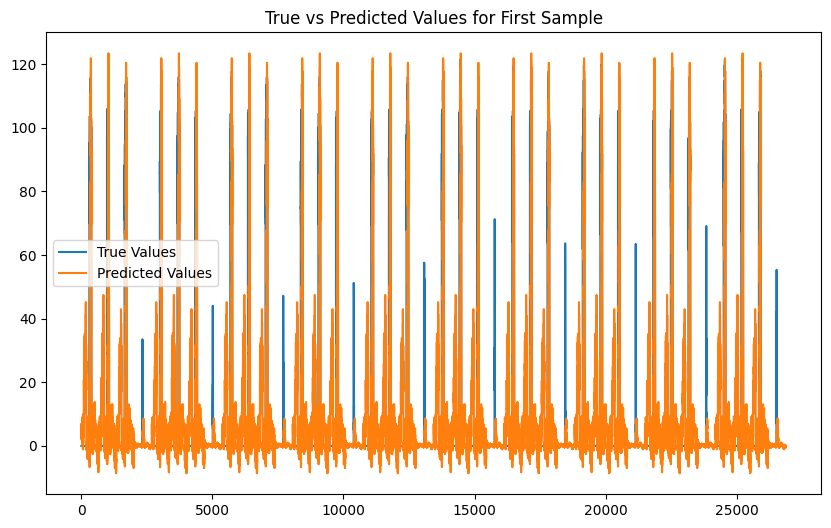

In [31]:
import matplotlib.pyplot as plt

# Plot a few predictions vs true values
plt.figure(figsize=(10,6))
plt.plot(y_test[0].flatten(), label='True Values')
plt.plot(y_test_pred[0].flatten(), label='Predicted Values')
plt.title('True vs Predicted Values for First Sample')
plt.legend()
plt.show()


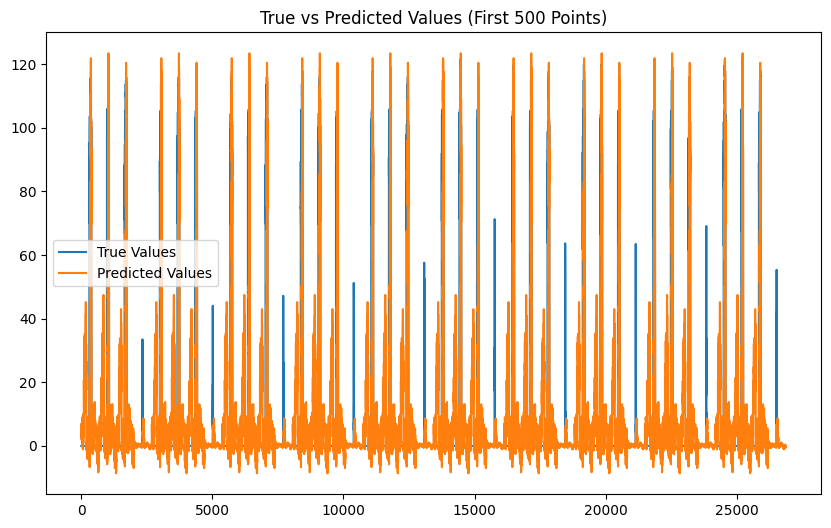

: 

In [32]:
plt.figure(figsize=(10,6))
plt.plot(y_test[0][:500].flatten(), label='True Values')
plt.plot(y_test_pred[0][:500].flatten(), label='Predicted Values')
plt.title('True vs Predicted Values (First 500 Points)')
plt.legend()
plt.show()


the extremely high score indicates that the data was not able to processed correctly with the pivoting method or either the extremely small sub sample was not able to build the model correctly. 
in the next models we will build lstm models with a different approach of preprocessing, further we will ommit the null values to see if it performs better that way in another model. 